In [327]:
import numpy as np

s = 300
X, Y = np.meshgrid(range(s), range(s), indexing='ij')
def getdigit(number, n):
    try:
        return int(str(number)[n])
    except IndexError:
        return 0

@np.vectorize
def powerlevel(x, y, gridserial):
    return getdigit(((x+10)*y + gridserial)*(x+10),-3) - 5

In [435]:
from scipy.signal import convolve2d
from sympy.ntheory.factor_ import primefactors
input=4455

# suboptimal. better version with stacked area table further down.

def mkkernel(dial, subdial=1):
    n = dial // subdial
    size = (n-1) * subdial + 1
    kernel = np.zeros((size, size), dtype=int)
    kernel[::subdial, ::subdial] = 1
    return kernel

durations = {}

grid_cache = {1: grid}
def powerlevel2(grid, dial=3):
    print('dial', dial)
    # largest factor = number / smallest prime factor
    spf = (primefactors(dial) + [dial])[0]
    subdial = dial // spf
    subgrid = grid_cache[subdial]
    
    kernel = mkkernel(dial, subdial)
    t = %timeit -r 1 -o convolve2d(subgrid, kernel, mode='valid')
    durations[dial] = t
    totpower = convolve2d(subgrid, kernel, mode='valid')
    
    assert (totpower == convolve2d(grid, np.ones((dial, dial)), mode='valid')).all()
    assert totpower.shape[0] == len(grid)-dial+1
    
    grid_cache[dial] = totpower
    maxtp = np.max(totpower)
    x, y = np.argwhere(totpower==maxtp)[0]
    return x, y, maxtp

In [195]:
dials = []

In [196]:
for dial in range(1, 15+1):
    x, y, maxpower = powerlevel2(grid, dial)
    dials.append((x, y, maxpower))

#dials = powerlevel2(np.arange(1, 300+1))
#print(dials)

dial 1
881 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
dial 2
1.63 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
dial 3
2.71 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
dial 4
2.66 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
dial 5
5.38 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
dial 6
3.81 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
dial 7
9.89 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
dial 8
5.17 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
dial 9
9.78 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
dial 10
6.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
dial 11
20.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
dial 12
9.57 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
dial 13
25.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
dial 14
11.7 ms ± 0 ns 

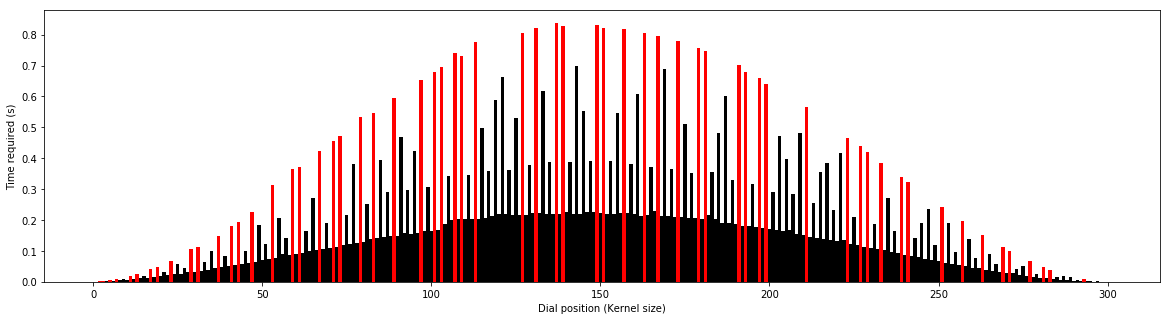

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt
from sympy.ntheory.primetest import isprime
def plot():
    pairs = [(dial, dur.best) for dial, dur in durations.items()]
    plt.figure(figsize=(20,5))
    plt.bar([p[0] for p in pairs], [p[1] for p in pairs], 
            color=[(isprime(dial), 0., 0.) for dial, dur in durations.items()],
           width=1.0)
    plt.ylabel('Time required (s)')
    plt.xlabel('Dial position (Kernel size)')
    plt.show()
    
plot()

In [436]:
np.argmax(np.array(dials)[:, 2])

26

In [368]:
sagcache = {}

In [403]:
bestdial_cache = {}

In [419]:
pl2_cache = {}

In [420]:
def get_sag(gridserial):
    try:
        return sagcache[gridserial]
    except KeyError:
        grid = powerlevel(X, Y, gridserial)
        sag = np.pad(grid.cumsum(axis=0).cumsum(axis=1), pad_width=((1, 0,),)*2, mode='constant')
        sagcache[gridserial] = sag
        return sag
    
def totpower(x, y, gridserial, dial=3):
    sag = get_sag(gridserial)
    return sag[x, y] - sag[x+dial, y] - sag[x, y+dial] + sag[x+dial, y+dial]


def pl2(gridserial, dial):
    try:
        return pl2_cache[gridserial, dial]
    except KeyError:
        lim = s-dial+1
        pg = totpower(X[:lim, :lim], Y[:lim, :lim], gridserial, dial)
        mpg = np.argmax(pg); mpg = np.unravel_index(mpg, pg.shape)
        rv = mpg[0], mpg[1], pg[mpg[0], mpg[1]]
        pl2_cache[gridserial, dial] = rv
        return rv
    

def find_best_dial(gridserial):
    try:
        #print('cached', end=';')
        return bestdial_cache[gridserial]
    except KeyError:
        dials = []
        for dial in range(1, 300+1):
            x, y, maxpower = pl2(gridserial, dial)
            dials.append((x, y, maxpower))
        dials = np.array(dials)
        bestdial = np.argmax(dials[:, 2])
        besttp = dials[bestdial, 2]
        rv = bestdial+1, (dials[bestdial, 0], dials[bestdial, 1])
        bestdial_cache[gridserial] = rv
        return rv

In [418]:
find_best_dial(455)

(11, (236, 268))

0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;101;102;103;104;105;106;107;108;109;110;111;112;113;114;115;116;117;118;119;120;121;122;123;124;125;126;127;128;129;130;131;132;133;134;135;136;137;138;139;140;141;142;143;144;145;146;147;148;149;150;151;152;153;154;155;156;157;158;159;160;161;162;163;164;165;166;167;168;169;170;171;172;173;174;175;176;177;178;179;180;181;182;183;184;185;186;187;188;189;190;191;192;193;194;195;196;197;198;199;200;201;202;203;204;205;206;207;208;209;210;211;212;213;214;215;216;217;218;219;220;221;222;223;224;225;226;227;228;229;230;231;232;233;234;235;236;237;238;239;240;241;242;243;244;245;246;247;248;249;250;251;252;253;254;255;256;257;258;259;260;261;262;263;264;265;266;267;268;269;270;271;272;273;274;275;276;27

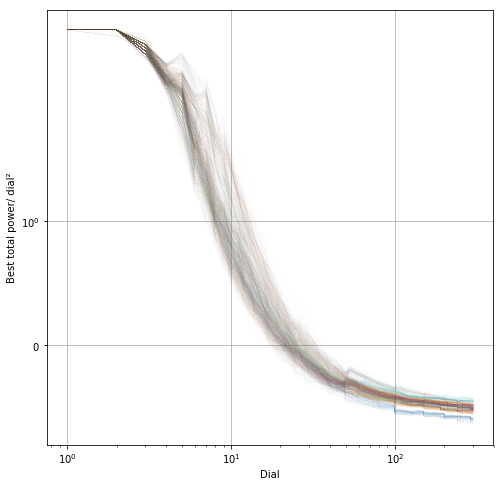

In [447]:
plt.figure(figsize=(8, 8))
plt.gca().set_yscale('symlog')
plt.gca().set_xscale('log')
plt.grid()
plt.ylabel('Best total power/ dial²')
plt.xlabel('Dial')

for gridserial in range(1000):
    print(gridserial, end=';')
    
    dials = []
    for dial in range(1, 300+1):
        x, y, maxpower = pl2(gridserial, dial)
        dials.append((x, y, maxpower))
    dials = np.array(dials)
    bestdial = np.argmax(dials[:, 2]) + 1
    besttp = dials[bestdial, 2]
    dialsize = np.arange(1, len(dials)+1)
    line = plt.plot(dialsize, dials[:, 2]/dialsize**2, lw=0.01, label=str(gridserial))[0]
    #plt.plot(bestdial, besttp, marker='.', alpha=0.3, color=line._color)
#plt.legend(title='Grid serial')

In [421]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

heatmap = np.zeros((s,s), dtype=np.int32)

plt.figure(figsize=(12, 12))

for i in range(1000):
    print(i, end=';')
    size, loc = find_best_dial(i)
    heatmap[loc[0]:loc[0]+size,loc[1]:loc[1]+size] += 1

plt.imshow(heatmap, interpolation='none')

In [434]:
# largest dial
max(bestdial_cache.items(), key=lambda x: x[1][0])

(3, (27, (227, 222)))

In [432]:
# largest power
max(pl2_cache.items(), key=lambda x: x[1][2])

((999, 27), (224, 222, 255))

-0.527111111111
True


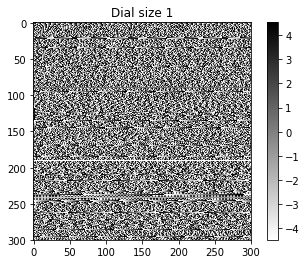

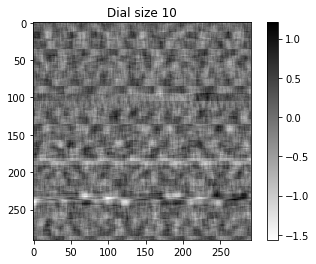

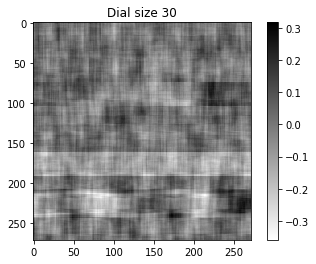

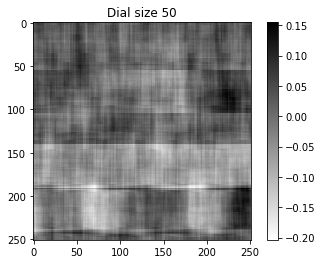

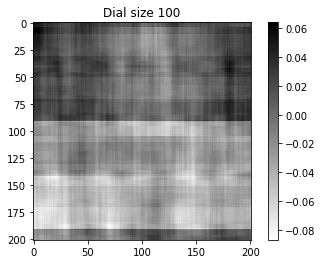

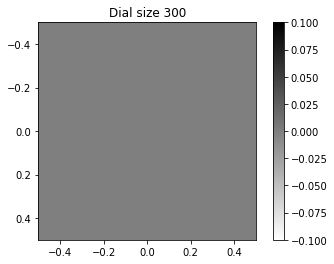

In [523]:
from matplotlib.colors import SymLogNorm, Normalize

grid = totpower(X, Y, 4455, 1)
avg = np.average(grid)
print(avg)
print(totpower(0, 0, 4455, 300)/(300*300) - avg == 0)
mn, mx = np.min(grid), np.max(grid)
dev = max(abs(mn), abs(mx))
norm=SymLogNorm(linthresh=0.1, vmin=-dev, vmax=dev)
#norm=Normalize(vmin=-100, vmax=1000)

def plot_grid(serial, dial):
    lim = s-dial+1
    grid = totpower(X[:lim, :lim], Y[:lim, :lim], serial, dial)
    deviation_from_average = grid/dial**2 - avg
    plt.title('Dial size {}'.format(dial))
    plt.imshow(grid/dial**2 - avg, cmap='binary')
    plt.colorbar()
    plt.show()
    
plot_grid(4455, 1)
plot_grid(4455, 10)
plot_grid(4455, 30)
plot_grid(4455, 50)
plot_grid(4455, 100)
plot_grid(4455, 300)